## 线性回归基础

+ 线性回归是对 n 维 输入的加权，外加偏差
+ 使用平方损失来衡量预测值和真实值的差异
+ 线性回归有显式解
> 显式解模型过于简单，显示意义不大（显示解就是可以用数学方法算出来的表达解）
+ 线性回归可以看做是单层神经网络

## 基础优化算法

+ 梯度下降通过不断沿着反梯度方向更新参数求解（“下山走陡坡最快”）
+ 小批量随机梯度下降是深度学习默认的求解算法
+ 两个重要的超参数是批量大小和学习率

## 线性回归的从零实现

我们将从零开始实现整个方法（不使用任何神经网络框架），包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [14]:
%matplotlib inline
# 具体作用是当你调用matplotlib.pyplot的绘图函数plot()进行绘图的时候，或者生成一个figure画布的时候，可以直接在你的python console里面生成图像。
import random
import torch
from d2l import torch as d2l
# jupyter notebook 可以注释下一行就可以安装 d2l
# !pip install d2l

根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数 $w = [2, -3.4]^{\top}$、$b = 4.2$ 和噪声 $\epsilon$ 生成数据集及其标签
$\mathbf{y}=\mathbf{X} \mathbf{w}+b+\epsilon$ ， $X$ 是随机数

In [15]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w))) 
    # X 这里是个矩阵，行数代表有多少个样本（num_examples），列数代表有多少个 features(有多少个特征)，也就是 w 的长度
    # X 随机化为服从均值为 0 ，标准差为 1的正态分布。torch.normal() 表示返回一个张量,张量里面的随机数是从相互独立的正态分布中随机生成的  
    y = torch.matmul(X, w) + b # 根据上面公式 y = Xw + b，matmul() 函数就是用于 tensor 相乘并且可以使用广播机制
    y += torch.normal(0, 0.01, y.shape) # 为了让这个问题更加复杂一点，加入了随机噪声 ϵ
    # 同理加入的 ϵ 随机化为服从均值为 0 ，标准差为 0.01 的正态分布，并且它的形状和 y 的长度是一样的
    return X, y.reshape((-1, 1))
    # 最后把 X，y 做成一个列向量返回
    # reshape 中 -1 表示自动计算，1 表示固定，即列向量为 1

true_w = torch.tensor([2, -3.4]) # 表示真实的 w 
true_b = 4.2 # 真实的 b
features, labels = synthetic_data(true_w, true_b, 1000)
# 这个函数返回的特征与标签，相当于分别把真实的房屋“关键因素”和对应的“房价”列出来。这一页的信息，相当于去市场调研收集真实的房屋数据

`features` 中的每一行都包含一个二维数据样本，`labels` 中的每一行都包含一维标签值（一个标量）

In [16]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([1.1057, 0.1656]) 
label: tensor([5.8477])


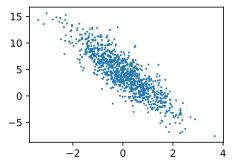

In [17]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
# 看一下训练样本长什么样子
# 其实这一步只是为了生成样本，如果已经有样本就不需要。

定义一个 `data_iter` 函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为 `batch_size` 的小批量

In [18]:
def data_iter(batch_size, features, labels):
    num_examples = len(features) # 1000
    indices = list(range(num_examples)) # 这一步可以理解为创建了一个尚未打乱顺序的数值为 0-999 的索引列表
    random.shuffle(indices) # random.shuffle(indices) # 可以理解为我打乱了这个索引列表
    # random.shuffle()用于将一个列表中的元素打乱顺序,值得注意的是使用这个方法不会生成新的列表,只是将原列表的次序打乱
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        # print(batch_indices) # 看不懂 可以注释掉这一句 看看 batch_indices 的结果是怎么样的形式
        # 看不懂这个循环的时候，想想这个函数我们最终要干什么？
        # 我们要 生成大小为 batch_size 的小批量 -> 得到这个小批量的索引 -> 从 features 和 labels 里面取值
        # i 从 0 到 999 开始每隔  batch_size 大小取值，然后batch_indices 为 indices 的切片的张量化
        # 切片从 i 开始，从 (i + batch_size, num_examples) 两者的最小值结束
        # 之所以要加最小值，是因为 indices 里面已经是打乱顺序了，假如取到了 999 还要 +10，那已经取不了了
        # 这里就是构造一个随机样本，饶是把样本的顺序打乱，然后间隔相同访问，也能达到随机的目的
        yield features[batch_indices], labels[batch_indices]
        # yield 就是 return 返回一个值，并且记住这个返回的位置，下次迭代就从这个位置后开始
        # return 返回以后函数就终止了，yield 是返回值以后继续执行这个函数
        # 创建data_iter 函数的目的，是从全样本集中抽取部分样本，以用来训练后面创建的模型
        
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    # X 就是一个 10 * 2 的 tensor，y 就是一个 10 * 1 的 tensor
    break
    # 如果没有 break，就会重复执行小批量的选取（100次），输出多组结果（可以注释看看）。这里老师估计就是想展示一组的效果而已 

tensor([[ 1.0116, -2.0370],
        [-1.2046, -0.3081],
        [-1.5527,  0.5589],
        [-0.5026,  1.5626],
        [-0.2446,  0.5570],
        [-1.5316,  0.4430],
        [ 0.2433,  0.1762],
        [ 0.7373, -1.2795],
        [-0.1073,  0.2173],
        [ 1.5407,  1.0479]]) 
 tensor([[13.1440],
        [ 2.8543],
        [-0.8085],
        [-2.1053],
        [ 1.8007],
        [-0.3717],
        [ 4.0964],
        [10.0317],
        [ 3.2629],
        [ 3.7171]])


定义初始化模型参数

In [19]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True) # b 是标量，size=1

定义模型

In [20]:
def linreg(X, w, b):
    """线性回归模型。"""
    return torch.matmul(X, w) + b

定义损失函数

In [21]:
def squared_loss(y_hat, y):
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

定义优化算法

In [22]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            # pytorch 会累加梯度，所以每更新一次参数，就要让其对应的梯度归零
# 自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值            
# 因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size）来归一化步长，这样步长大小就不会取决于我们对批量的选择

训练过程

In [23]:
# lr 表示学习率，实际上可以调节学习率大小观察下面的 loss 
# 比如将学习率调成很小时，例如： 0.001，结果就会导致 loss 一直会很高
# 反过来，如果将学习率 lr 调过高例如：10，结果就会导致无法收敛，loss 的值是 nan(not a number)
# 有一点需要注意的是，每次调学习率之后，不能只在本 cell 运行，还需要重新初始化上面的模型参数，即重新 run In(18) ,再 run 本 cell 方可看到正确的 loss
lr = 0.03
num_epochs = 3 # 迭代周期个数
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # `X` 和 `y` 的小批量损失
        # 因为 `l` 形状是(`batch_size`, 1), 而不是一个标量。 `1` 中所有的元素被加到一起
        # 并因此计算关于 [`w`, `b`] 的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 是用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.037618
epoch 2, loss 0.000137
epoch 3, loss 0.000048


>因为我们使⽤的是⾃⼰合成的数据集，所以我们知道真正的参数是什么。因此，我们可以通过⽐较真实参数
和通过训练学到的参数来评估训练的成功程度。事实上，真实参数和通过训练学到的参数确实⾮常接近。

比较真实参数和通过训练学到的参数来评估训练的成功程度

In [24]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([ 0.0002, -0.0001], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0009], grad_fn=<RsubBackward1>)


---

## 线性回归的简洁实现
>通过深度学习框架的⾼级 API 来实现我们的模型只需要相对较少的代码。我们不必单独分配参数、不必定义我们的损失函数，也不必⼿动实现⼩批量随机梯度下降。

通过**使用深度学习框架**来简洁地实现线性回归模型生成数据集

In [25]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

# 这一步还是一样的，先人工建一个数据集
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

调用框架中现有的 API 来读取数据

In [26]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个 Pytorch 迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

# TensorDataset: 把输入的两类数据进行一一对应
# DataLoader: 重新排序

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[-0.6594,  0.4068],
         [ 0.8544,  0.3592],
         [-0.6163,  0.9322],
         [ 0.2549,  0.3801],
         [-1.2777, -0.5425],
         [-0.4411,  1.0913],
         [ 1.3186, -1.3672],
         [ 0.0190,  0.9776],
         [-0.2174,  0.2146],
         [-0.5038,  0.2465]]),
 tensor([[ 1.5151],
         [ 4.6839],
         [-0.2037],
         [ 3.4298],
         [ 3.4867],
         [-0.4077],
         [11.4967],
         [ 0.9138],
         [ 3.0250],
         [ 2.3440]])]

使用框架的预定义好的层

In [27]:
# `nn` 是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))
# Sequential 一个有序的容器，神经网络模块将按照在传入构造器的顺序依次被添加到计算图中执行
# 同时神经网络模块为元素的有序字典也可以作为传入参数
# 在PyTorch中，全连接层在Linear类中定义。
#值得注意的是，我们将两个参数传递到nn.Linear中。第⼀个指定输⼊特征形状，即 2 ;第⼆个指定输出特征形状，输出特征形状为单个标量，因此为 1。


初始化模型参数

In [28]:
net[0].weight.data.normal_(0, 0.01)
# net[0] 是指容器里面的第一层，也就是我们的 Linear
net[0].bias.data.fill_(0)

tensor([0.])

计算均方误差使用的是 `MSELoss` 类，也成为平方 $L_2$ 范数，默认情况下，他返回所有样本损失的平均值

In [29]:
loss = nn.MSELoss()

实例化 `SGD` 实例

In [30]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)
# PyTorch在optim模块中实现了该算法的许多变种
#当我们实例化⼀个SGD实例时，我们要指定优化的参数（可通过net.parameters()从我们的模型中获得）以及优化算法所需的超参数字典。⼩批量随机梯度下降只需要设置lr值，这⾥设置为0.03。

训练过程代码与我们从零开始实现时所做的非常相似，而这里的步骤为：
+ 通过调⽤ net(X) ⽣成预测并计算损失 l（前向传播）。
+ 通过进⾏反向传播来计算梯度。
+ 通过调⽤优化器来更新模型参数。

In [31]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000356
epoch 2, loss 0.000101
epoch 3, loss 0.000101


+ 我们可以使⽤ PyTorch 的⾼级 API 更简洁地实现模型。
+ 在PyTorch中，data 模块提供了数据处理⼯具，nn 模块定义了⼤量的神经⽹络层和常⻅损失函数。
